## Capítulo 11 - Seleção do modelo

Este capítulo discutirá a otimização de hiperparâmetros. Também explorará a questão acerca de o modelo exigir dados para ter um melhor desempenho.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)

from sklearn.ensemble import (
    RandomForestClassifier,
)

from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

from yellowbrick.model_selection import (
    ValidationCurve,
)

from yellowbrick.model_selection import (
    LearningCurve,
)

In [2]:
# Caminho em Pasta
path = "datasets/titanic/titanic3.xls"
df = pd.read_excel(path)
orig_df = df

In [3]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### Curva de validação

Criar uma curva de validação é uma forma de determinar um valor apropriado para um hiperparâmetro. Uma curva de validação é um gráfico que mostra como o desempenho do modelo responde a mudanças no valor do hiperparâmetro

No exemplo a seguir, usaremos o 'Yellowbrick'para ver se uma modificação no valor do hiperparâmetro 'max_depth' altera o desempenho de um modelo de floresta aleatória (random forest). Podemos fornecer um parâmetro  'scoring' definido com uma métrica de um modelo do scikit-learn (o default para uma classificação é 'accuracy').

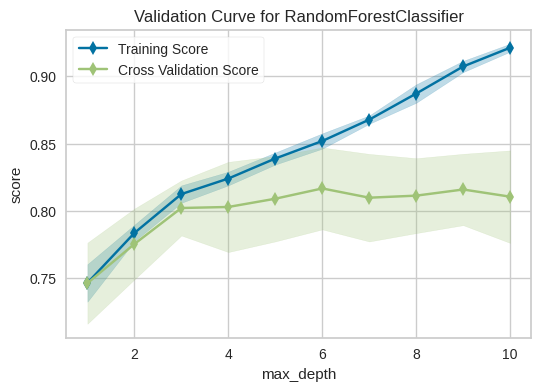

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
vc_viz = ValidationCurve(
    RandomForestClassifier(n_estimators=100),
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    n_jobs=-1,
)
vc_viz.fit(X, y)
vc_viz.poof()
fig.savefig("images/mlpr_1101.png", dpi=300)

A classe 'ValidationCurve' aceita um parâmetro 'scoring'. O parâmetro pode ser uma função personalizada ou uma das opções a seguir, conforme a tarefa.

-> As opções de scoring para classificação incluem: 'accuracy', 'average_precision', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_samples', 'neg_log_loss', 'precision', 'recall', 'roc_auc'.
    
-> As opções de scoring para clustering são: 'adjusted_mutual_info_score', 'adjusted_rand_score', 'completeness_score', 'fowlkesmallows_score', 'homogeneity_score', 'mutual_info_score', 'normalized_mutual_info_score' e 'v_measure_score'.
    
-> As opções de scoring para regressão são: 'explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error' e 'r2'.

### Curva de aprendizagem

Para selecionar o melhor modelo para o seu projeto, quantos dados serão necessários? Uma curva de aprendizado pode nos ajudar a responder a essa pergunta. O gráfico mostra as instâncias de treinamento e a pontuação para validação cruzada à medida que criamos modelos com mais amostras. Se a pontuação da validação cruzada continuar a subir, por exemplo, poderá ser um sinal de que mais dados ajudariam o modelo a ter um melhor desempenho.

Se houver variabilidade (uma área sombreada grande) na pontuação dos dados de treinamento, é sinal de que o modelo sofre de erros de bias e é simples demais (há subadequação). Se houver variabilidade na pontuação para validação cruzada, é porque o modelo está sujeito a erros de variância e é complicado demais (há superadequação). Outro sinal de que o modelo apresenta superadequação é o fato de que o desempenho para o conjunto de dados de validação é muito pior do que o desempenho para o conjunto de dados de treinamento.

A seguir, mostramos um exemplo de como criar uma curva de aprendizagem usando o Yellowbrick:

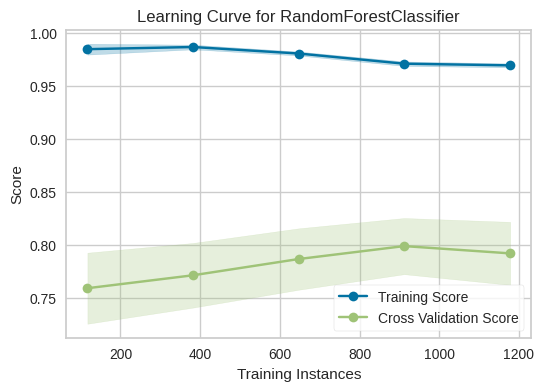

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
lc3_viz = LearningCurve(
    RandomForestClassifier(n_estimators=100),
    cv=10,
)
lc3_viz.fit(X, y)
lc3_viz.poof()
fig.savefig("images/mlpr_1102.png", dpi=300)

Essa visualização também pode ser usada para regressão ou clustering, se modificada as opções de pontuação.